# Importing all the libraries required

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout,Conv2D, MaxPooling2D, ZeroPadding2D,Dropout
from tensorflow.keras.regularizers import l2

# GPU configuration

In [1]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
#Using Image data geerator for data augmentation

In [2]:
img_width, img_height = 224, 224
TrainingImagePath = 'D:/University 3rd year/Team Project and Professionalism/Face Images/Final Training Images'
TestingImagePath = 'D:/University 3rd year/Team Project and Professionalism/Face Images/Final Testing Images'
batch_size = 32

In [3]:

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        validation_split=0.3,
        rotation_range=10,
        horizontal_flip=True)
 

# Generating the Training Data
training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        subset='training',
        class_mode='categorical')
 
 
# Generating the Testing Data
test_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        #color_mode='grayscale',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        subset = 'validation',
        class_mode='categorical')
 
# Printing class labels for each face
test_set.class_indices
#training_set.class_indices

Found 215 images belonging to 4 classes.
Found 92 images belonging to 4 classes.


{'Alexadru': 0, 'Diana': 1, 'Sebastian': 2, 'Unknown': 3}

In [4]:
# class_indices have the numeric tag for each face
TrainClasses=test_set.class_indices
 
# Storing the face and the numeric tag for future reference
ResultMap={}
for faceValue,faceName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[faceValue]=faceName
 
# Saving the face map for future reference
import pickle
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)
 
# The model will give answer as a numeric tag
# This mapping will help to get the corresponding face name for it
print("Mapping of Face and its ID",ResultMap)
 
# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: 'Alexadru', 1: 'Diana', 2: 'Sebastian', 3: 'Unknown'}

 The Number of output neurons:  4


# Importing a pre-trained model from keras using the weights from imagenet

In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
base_model=tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=input_shape,
    weights="imagenet"

)

for layer in base_model.layers:
        layer.trainable = False


# Fine tunning the base model by createing the top layers required for training on this dataset

In [6]:
num_classes = 4
base_learning_rate = 0.0001
base_input=base_model.layers[0].input
base_output=base_model.layers[-1].output



final_output=layers.Flatten()(base_output)

final_output=layers.BatchNormalization()(final_output)
final_output=layers.Dense(256,activation='relu',kernel_regularizer=l2(base_learning_rate))(final_output)
final_output=layers.BatchNormalization()(final_output)

final_output=layers.Dense(256,activation='relu',kernel_regularizer=l2(base_learning_rate))(final_output)
final_output=layers.Dense(num_classes,activation='softmax')(final_output)


new_model=tf.keras.Model(inputs=base_input,outputs=final_output)
new_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Training the model and saveing the it at the and of each epoch

In [7]:
from tensorflow.keras.callbacks import History
history=History()

In [8]:
directory='Checkpoint'
name='Model'
saved = os.path.join(directory, name + "-{epoch:02d}.h5")
callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=saved, monitor='val_accuracy', verbose=0, save_best_only=False,
    save_weights_only=False, mode='max', save_freq='epoch'
)
history=new_model.fit(
        training_set,
        epochs=10,
        callbacks=[callback,history],
        steps_per_epoch=215// batch_size,
        validation_data=test_set,
        validation_steps= 92  // batch_size)

Epoch 1/10
6/6 [==============================] - 10s 889ms/step - loss: 1.5840 - accuracy: 0.3482 - val_loss: 0.8506 - val_accuracy: 0.7188
Epoch 2/10
6/6 [==============================] - 3s 450ms/step - loss: 0.9115 - accuracy: 0.6826 - val_loss: 0.7128 - val_accuracy: 0.7656
Epoch 3/10
6/6 [==============================] - 2s 378ms/step - loss: 0.6461 - accuracy: 0.8020 - val_loss: 0.6170 - val_accuracy: 0.7656
Epoch 4/10
6/6 [==============================] - 2s 389ms/step - loss: 0.5252 - accuracy: 0.8684 - val_loss: 0.3112 - val_accuracy: 0.9062
Epoch 5/10
6/6 [==============================] - 2s 392ms/step - loss: 0.3921 - accuracy: 0.9525 - val_loss: 0.2579 - val_accuracy: 0.9375
Epoch 6/10
6/6 [==============================] - 2s 380ms/step - loss: 0.3870 - accuracy: 0.9467 - val_loss: 0.1161 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 2s 400ms/step - loss: 0.2893 - accuracy: 0.9895 - val_loss: 0.1388 - val_accuracy: 0.9844
Epoch 8/10
6/6 [===

# Plotting the result

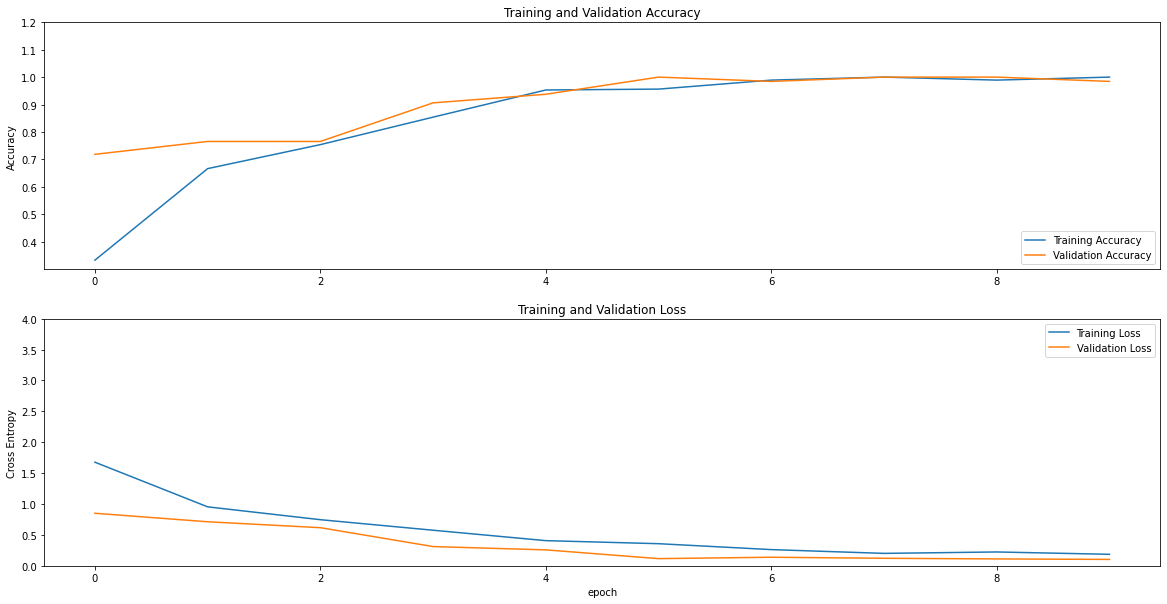

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()